# Data Exploration

This notebook exercises some utility functions to load and explore the data.
It assumes that you have downloaded the training data and placed it in a `data` directory at the top of the repository.

We will use both `plotly` and `matplotlib` for displaying plots, charts and images. We also define some utilities that may be also elsewhere in this project.

In [1]:
import sys, os

sys.path.append('..')
import planet.util

import plotly
plotly.offline.init_notebook_mode(connected=True)

import matplotlib
import matplotlib.pyplot as plt

import numpy, skimage.io, tqdm

data_dir = '../data'

## Tags

First we load the tags and count their occurrences. We use the word *tag* to refer to a word that refers to a tag/label/class associated with an image like *clear*, *habitation*, and *primary*. Later we will use the word *label* to refer to the binary vector associated with an image that describes all its tags.

In [2]:
train_tags = planet.util.read_tags(os.path.join(data_dir, 'train_v2.csv'))
num_samples = len(train_tags)
train_tags_counts = planet.util.count_tags(train_tags)
train_tags_counts_fig = plotly.graph_objs.Figure(
    data=[
        plotly.graph_objs.Bar
        (
            x=list(train_tags_counts.keys()),
            y=list(train_tags_counts.values())
        )
    ],
    layout=plotly.graph_objs.Layout(
        title='Counts of Training Tags from {} Samples'.format(num_samples)
    )
)
plotly.offline.iplot(
    train_tags_counts_fig,
    filename=os.path.join(data_dir, 'train_tags_counts.html')
)

The distribution of tags is very non-uniform. A few tags occur very frequently, like *primary* and *clear*, whereas others occur hardly at all, like *conventional_mine* and *blow_down*. This is expected as we were told that the tags can be separated into three groups: atmospheric conditions or cloud cover, commond land cover/use, and rare land cover/use.

Note that *bare_ground* is defined by Planet as a common land cover/use, but only occurs 862 times. In this sense the hard division between rare and common covers/uses may not be that meaningful, however any solution should likely take into account the rarity of certain tags like *conventional_mine* and *blow_down*. In an extreme case, we may wish to drop those tags to simplify the problem and improve accuracy of predicting the more common tags.

Remember that each sample can have many tags associated with it. Therefore, we now look at how frequently the tags co-occur with each other in the same sample.

In [3]:
tag_indices = planet.util.get_tag_indices(train_tags)
train_labels = planet.util.tags_to_labels(train_tags, tag_indices).astype(int)
train_tag_co_counts = train_labels.transpose().dot(train_labels)
numpy.fill_diagonal(train_tag_co_counts, 0)

train_tags_co_counts_fig = plotly.graph_objs.Figure(
    data=[
        plotly.graph_objs.Heatmap
        (
            z=train_tag_co_counts,
            x=list(tag_indices.keys()),
            y=list(tag_indices.keys()),
        )
    ],
    layout=plotly.graph_objs.Layout(
        title='Co-occurence Counts of Training Tags from {} Samples'.format(num_samples)
    )
)
plotly.offline.iplot(
    train_tags_co_counts_fig,
    filename=os.path.join(data_dir, 'train_tags_co_counts.html')
)

Unfortunately, the co-occurrence counts are not that useful because they are dominated by the tags that occur frequently in the first place. In order to normalize this effect, we consider the conditional probability of seeing one tag given another.

In [38]:
train_tag_co_counts_float = train_tag_co_counts.astype(float)
train_tag_co_counts_sum = numpy.sum(train_tag_co_counts, axis=1, keepdims=True)
train_tag_cps = numpy.divide(train_tag_co_counts_float, train_tag_co_counts_sum,
                             out=numpy.zeros_like(train_tag_co_counts_float), where=train_tag_co_counts_sum!=0)

train_tags_cps_fig = plotly.graph_objs.Figure({
    data=[
        plotly.graph_objs.Heatmap
        (
            z=train_tag_cps,
            x=list(tag_indices.keys()),
            y=list(tag_indices.keys()),
        )
    ],
    layout=plotly.graph_objs.Layout(
        title='Co-occurence Conditional Probabilities of Training Tags from {} Samples'.format(num_samples)
    )
)
plotly.offline.iplot(
    train_tags_cps_fig,
    filename=os.path.join(data_dir, 'train_tags_cps.html')
)

The way to read this figure is that the conditional tag is defined by the row. For example, the first row defines the probability of observing the other tags given that the *blow_down* tag has been observed. 

Again, we see that the frequent *primary* and *clear* tags dominate, as given most tags these co-occur with relatively high probability (i.e. greater than 0.2).

An obvious exception is that the *partly_cloudy* and *haze* tags never co-occur with *clear*, as one would expect. Also notice that, as we were told, the *cloudy* tag does not co-occur with any other tag. These kinds of deterministic rules may need to be built in to any tag predictor.

Even though there are no striking relationships between pairs of tags, there are a few interesting ones.

For example, given that the *blooming* tag occurs, almost all other tags except *primary* and *clear*, most of which are associated with human activity, do not occur, which may suggest that *blooming* may not frequently occur in the presence of human activitiy.

Another example is that given the *artisinal_mine* tag occurs, the *water* tag co-occurs with relatively high probability. In Planet's description of the tags, they state that artisinal miners *"slash through the forest and excavate deep pits near rivers"* which corroborates this finding.

Finally, given certain tags like *selective_logging*, *conventional_mine* and *habitation*, the *road* tag co-occurs with higher probability than usual, as one would expect these man-made phenomena to often require roads.

## Images

Next, we plot an example image for each tag.

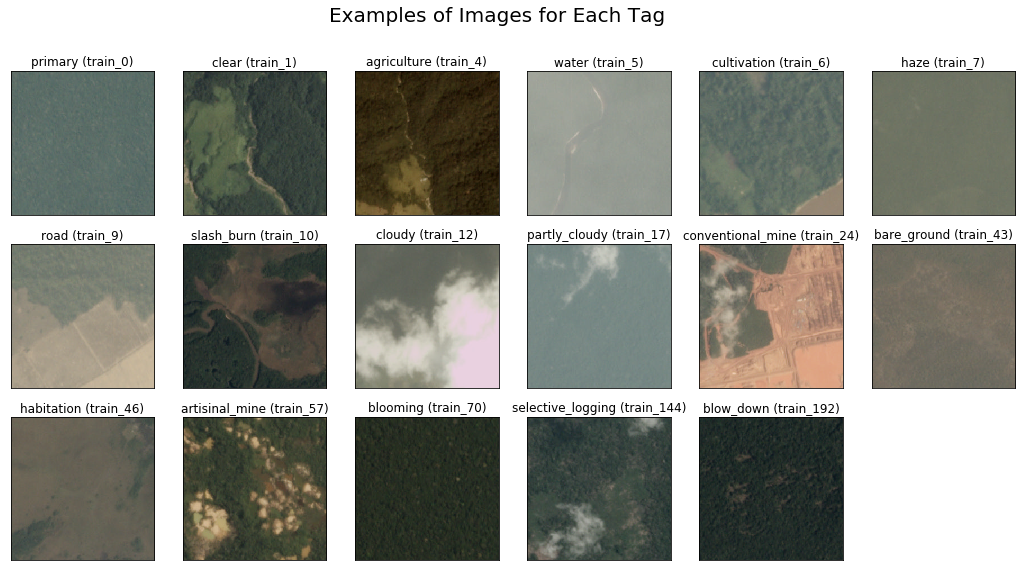

In [6]:
image_fig = plt.figure(figsize=(18, 9))
image_fig.suptitle('Examples of Images for Each Tag', fontsize=20)
example_tags = set()
for sample, tag_list in train_tags.items():
    diff = set(tag_list) - example_tags
    if len(diff) > 0:
        tag = diff.pop()
        example_tags.add(tag)
        image = skimage.io.imread(os.path.join(data_dir, 'train-jpg/{}.jpg'.format(sample)))
        i = len(example_tags)
        ax = image_fig.add_subplot(3, 6, i)
        ax.set_title("{} ({})".format(tag, sample))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(image)
        if i >= 18 or i == len(train_tags_counts):
            break

plt.show()

A very preliminary observation is that **color** may play an important role is assigning tags to images. For example, *cloudy* clearly contains many white pixels, *primary* contains many green pixels and *habitation* contains many brown pixels. Other tags are more associated with structure and texture, such as *road* and *selective_logging*.

Therefore, next we compute the average RGB triple associated with each tag.

In [14]:
train_tag_rgb = numpy.zeros((len(tag_indices), 3))

with tqdm.tqdm(train_tags.keys()) as pbar:
    for sample, tag_list in train_tags.items():
        image = skimage.io.imread(os.path.join(data_dir, 'train-jpg/{}.jpg'.format(sample)))
        mean_rgb = numpy.mean(image, axis=(0, 1))
        for tag in tag_list:
            train_tag_rgb[tag_indices[tag], :] += mean_rgb
        pbar.update()
        
train_tag_rgb /= numpy.sum(train_labels, axis=0, keepdims=True).transpose()

train_rgb_fig = plotly.graph_objs.Figure(
    data=[
        plotly.graph_objs.Bar
        (
            x=list(tag_indices.keys()),
            y=list(train_tag_rgb[:, 0]),
            name='Red',
            marker={'color' : 'rgb(255, 0, 0)'},
        ),
        plotly.graph_objs.Bar
        (
            x=list(tag_indices.keys()),
            y=list(train_tag_rgb[:, 1]),
            name='Green',
            marker={'color' : 'rgb(0, 255, 0)'},
        ),
        plotly.graph_objs.Bar
        (
            x=list(tag_indices.keys()),
            y=list(train_tag_rgb[:, 2]),
            name='Blue',
            marker={'color' : 'rgb(0, 0, 255)'},
        ),
    ],
    layout=plotly.graph_objs.Layout(
        title='Mean RGB Values of Images Associated with Tags',
        barmode='group'
    )
)

plotly.offline.iplot(
    train_rgb_fig,
    filename=os.path.join(data_dir, 'train_tags_rgb.html')
)

100%|██████████| 40479/40479 [03:36<00:00, 186.75it/s]


While these RGB statistics are quite crude, they do confirm some of our suspicions.

For example, *artisinal_mine*, *bare_ground*, and *conventional_mine* contain more red than green, which is uncommon among other tags where green tends to dominate red as expected in images of the Amazon rainforest. The blue channel does not seem to vary in an interesting way, other than perhaps as an indication of the overall intensity level of image.

Also note that the clarity tags can be quite easily sorted by overall intensity in ascending order: *clear*, *partly_cloudy*, *haze*, and *cloudy*. This suggests that we may want to split the classification into two problems. One to assign a clarity label, which may be quite simple to solve, and another to assign the other labels, which is likely more complex.

## Summary

1. The distribution of land cover tags is very non-uniform. I would recommend that any classifier would likely benefit from taking that distribution into account.

2. We were told that each image will have at least one cloud cover tag, but based on the training data, each image has **exactly** one cloud cover tag. Therefore, I would recommend splitting this problem into two sub-problems. Assignment of exactly one cloud cover tag, followed by assignment of zero or many land cover tags. Note that the *cloudy* tag implies that there are zero land cover tags. The *haze* and *partly_cloudly* tags may decrease the probability of observing certain land cover tags compared to *clear*, but that is not obvious so far.

3. The images associated with cloud cover tags have very different overall intensities. I would recommend trying a simple classifier based on this scalar statistic.

4. Color is clearly important to many of the tags, but not in a straightforward way. Classification methods must be able to handle the channels of color images in a sensible way. The blue channel may not be particularly informative, except perhaps for the *water* tag.